# Project: Write a Data Science Blog Post - COVID19 Global Forecasting

CRISP method for Data Analysis using Covid-19 Global Forecasting Dataset, [Kaggle](https://www.kaggle.com/c/covid19-global-forecasting-week-2)

# Table of contents

<ol>
    <li><a href="#1.Introduction">Introduction</a></li>
    <li><a href="#2.Business-understanding">Business understanding</a></li>
    <li><a href="#3.Data-understanding">Data understanding</a></li>
    <li><a href="#4.Data-preparation">Data preparation</a></li>
    <li><a href="#5.Data-modelling">Data modelling</a></li>
    <li><a href="#6.Conclusion">Conclusion</a></li>
</ol>

## <h2>1.Introduction</h2>

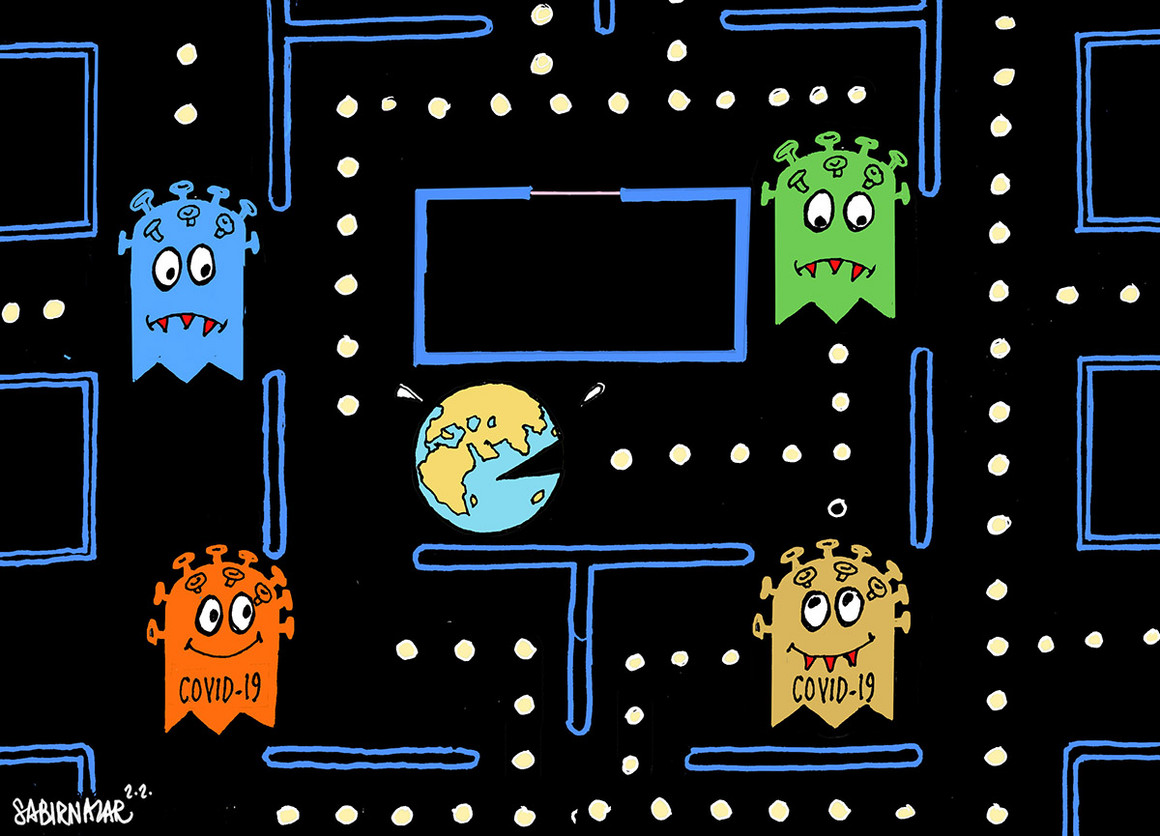

The World Health Organization has declared the outbreak the COVID-19 pandemic and it has spread to more than 190 countries around the world. 
In spite of that, Kaggle have lauched the COVID19 Global Forecasting, in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution.
This notebook provides a visual narrative of the spread of Covid-19 so please check back often as we will be refreshing it with new graphics and features as the story evolves.

## <h2>2.Business understanding<h2>

![alt text](coronavirus_research.png)

Let us assume of a moment to live on a star and watch the planet hearth from it!
Under this assumption, we are not aware of the shocking Pandemia we are all going trough.
Let us take a further abstraction step and let us consider that, from that star, we have the acces to 
the nice and controversial cyber-world called: The Internet.
Scaping the web as well as we could do with the galaxies aroud us, we come accross the Kaggle platform.
We decide to get involved in a data analysis afternoon as we are courious to know the following:

<ol>
    <li>What is the impact of the COVID-19 worldwide?</li>
    <li>Which countries are the most affected by the virus?</li>
    <li>Which is the average mortality range?</li>
    <li>How is it related to the date-time?</li>
    <li>Can we predict the next moth fatality cases and confirmed cases?</li>
<ol>

## <h2>3.Data understanding<h2>

In [141]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import plotly.offline as py

import plotly.express as px
from plotly.graph_objs import Figure
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

py.init_notebook_mode(connected=True)

In [142]:
train = pd.read_csv('covid19-global-forecasting-week-2/train.csv')
train = train.rename(columns={'Country_Region':'Country','Province_State':'State'})

## 3.1 Exploratory Data Analysis

In [143]:
print('Train shape: {}'.format(train.shape))
print('Features variables: {}'.format(set(train.columns[1:4])))
print('Target variables: {}'.format(set(train.columns[4:])))
print('Time period: from {} to {}'.format(train['Date'].unique()[0], train['Date'].unique()[-1]))
print("Number of days: {} ".format(train['Date'].nunique()))
print('Number of Countries involved in the analysis: {}'.format(train['Country'].nunique()))
print('Number of State involved in the analysis: {}'.format(train['State'].nunique()))
print('The column State in the train set contains {}'.format(train.isnull().sum()[1]) + ' NaN values, no other missing values are detected')
print('Number of Countries with missing State entries in the train set: {}'.format(len(list(train.loc[train.isnull().any(1), 'Country'].unique()))))
print("Countries with State information: {}".format(train[train['State'].isna()==False]['Country'].unique()))
print('Number of countries with no missing State entries in the train set: {}'.format([train.loc[(train['Country']==country)&(train['State'].isnull())][['State']].shape[0] for country in list(train['Country'].unique())].count(0)))
print('Number of missing State entries per country in the train set: {}'.format([train.loc[(train['Country']==country)&(train['State'].isnull())][['State']].shape[0] for country in list(train['Country'].unique())][1]))

Train shape: (19110, 6)
Features variables: {'State', 'Country', 'Date'}
Target variables: {'ConfirmedCases', 'Fatalities'}
Time period: from 2020-01-22 to 2020-03-26
Number of days: 65 
Number of Countries involved in the analysis: 173
Number of State involved in the analysis: 125
The column State in the train set contains 10985 NaN values, no other missing values are detected
Number of Countries with missing State entries in the train set: 169
Countries with State information: ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']
Number of countries with no missing State entries in the train set: 4
Number of missing State entries per country in the train set: 65


In [144]:
confirm_check_train = train.ConfirmedCases.value_counts(normalize=True)
fatal_check_train = train.Fatalities.value_counts(normalize=True)
n_confirm_train = train.ConfirmedCases.value_counts()[1:].sum()
n_fatal_train = train.Fatalities.value_counts()[1:].sum()
n_train = train.shape[0]
print('Percentage of confirmed case records : {0:<2.0f}/{1:<2.0f} = {2:<2.1f}%'.format(n_confirm_train, n_train, confirm_check_train[1:].sum()*100))
print('Percentage of fatality records : {0:<2.0f}/{1:<2.0f} = {2:<2.1f}%'.format(n_fatal_train, n_train, fatal_check_train[1:].sum()*100))
print('Number of Confimed cases in the whole world untill {}: {}'.
      format(train['Date'].unique()[-1],int(train['ConfirmedCases'].sum())))
print('Number of Fatalities in the whole world untill {}: {}'.
      format(train['Date'].unique()[-1],int(train['Fatalities'].sum())))
print('Top five Countries for number of Fatalities: {}'.format(set(train.groupby(by=['Country']).sum()['Fatalities'].sort_values(ascending=False)[0:5].reset_index()['Country'])))
print('Top five Countries for number of Confirmed Cases: {}'.format(set(train.groupby(by=['Country']).sum()['ConfirmedCases'].sort_values(ascending=False)[0:5].reset_index()['Country'])))
print('Top five State for number of Fatalities: {}'.format(set(train.groupby(by=['Country','State']).sum()['Fatalities'].sort_values(ascending=False)[0:5].reset_index()['State'])))
print('Top five State for number of ConfirmedCases: {}'.format(set(train.groupby(by=['Country','State']).sum()['ConfirmedCases'].sort_values(ascending=False)[0:5].reset_index()['State'])))

Percentage of confirmed case records : 7917/19110 = 41.4%
Percentage of fatality records : 3086/19110 = 16.1%
Number of Confimed cases in the whole world untill 2020-03-26: 6985376
Number of Fatalities in the whole world untill 2020-03-26: 262414
Top five Countries for number of Fatalities: {'Iran', 'France', 'China', 'Italy', 'Spain'}
Top five Countries for number of Confirmed Cases: {'Iran', 'US', 'China', 'Italy', 'Spain'}
Top five State for number of Fatalities: {'New York', 'Henan', 'Hubei', 'Washington', 'Heilongjiang'}
Top five State for number of ConfirmedCases: {'New York', 'Zhejiang', 'Guangdong', 'Henan', 'Hubei'}


The dataset covers 163 countries, it consits of almost 2 full months from 2020 with daily granularity. 
Europe became the focal point of the disease in early March when it spread rapidly across the continent and 
Italy became the country hardest hit by Covid-19 after China. 
After weeks of strict lockdown, Italy is on the verge of turning the corner and the rate of deaths is beginning to decrease. 
The US is still in the acceleration phase.

## 3.2 Data Visulatization

In this section, we visualize the daily impact of the virus and how COVID-19 has been growing throughout 
the world from 22nd January 2020. 

In [147]:
formated_gdf = train.groupby(['Date', 'Country'])['ConfirmedCases', 'Fatalities'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['Size'] = formated_gdf['ConfirmedCases'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country", locationmode='country names', 
                     color="ConfirmedCases", size='Size', hover_name="Country", 
                     range_color= [0, 1500], 
                     projection="natural earth", animation_frame="Date", 
                     title='COVID-19: Spread Over Time', color_continuous_scale=px.colors.sequential.Viridis,
                    template='plotly_dark')
fig.show()

In [148]:
grouped = train.groupby('Date')['Date', 'Fatalities'].sum().reset_index()

(px.line(grouped, x="Date", y='Fatalities',
        log_y=False,
        title=" Worldwide Fatalities Cases Over Time",
        template="plotly_dark"
        ))

In [149]:
(px.line(grouped, x="Date", y='Fatalities',
        log_y=True,
        title="COVID-19: Worldwide Fatalities Cases (Logarithmic Scale) Over Time",
        template="plotly_dark",  # see https://plot.ly/python/templates/
        ))

In [150]:
missing_state_countries = list(train.loc[train.isnull().any(1), 'Country'].unique())
train_missing_state_countries = train[train['Country'].isin(missing_state_countries)]
tipping_point =100
train_tip_point = train_missing_state_countries[train_missing_state_countries['Fatalities']>= tipping_point]
(px.line(train_tip_point, 
        x="Date",
        y="Fatalities",
        log_y=False,
        color="Country", 
        title="Total number of fatalities from common tipping point",
        template="plotly_dark",  # see https://plot.ly/python/templates/
        )
   .for_each_trace(lambda t: t.update(name=t.name.replace("Country=","")))
)

China was the first country to experience the onset of virus.
US and Italy, which are the worst affected countries currently did not record many cases in January. 
This shows that how fast the virus spreads.
Majority of the cases are in the northern hemisphere, which is relatively cooler at this time of the year. 
Maybe the virus is temperature sensitive and as the summer progresses, 
we may see a fall in the growth of the cases in the northern hemisphere. 
Western Europe is the worst affected. Hence, it can be adjudged as the new epicenter of COVID19.
USA is also in the reckoning.
Lockdown has seem to have worked in China's favour as the growth rate has plummeted.
It can be seen that a raise in maximum number of new cases appears between the 11th and the 18th of Feabruary, 
after which China reached its saturation point. Then a new sudden rise appears after March 24th, 
when the total new cases world wide crosses the total affectees in China alone.
Since March 11th, the death toll rises steeply due to extreme rise in European countires, 
specially Italy, Spain, France and UK, and as well as now in US. 

In [151]:
train_data_by_country = train.groupby(['Country'],as_index=False).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_by_country_confirm = train_data_by_country.sort_values(by=["ConfirmedCases"], ascending=False)

top_10_country = train_data_by_country_confirm[:10]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=top_10_country['Country'],
    y=top_10_country['ConfirmedCases'],
    name='Confirmed Cases',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=top_10_country['Country'],
    y=top_10_country['Fatalities'],
    name='Fatalities > 200',
    marker_color='lightsalmon'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, title ='Top 10 Countries with Maximum Confirmed Cases and Fatalities')
fig.show()

In [152]:
rate = train_df.groupby(by = 'Country').sum().reset_index()
rate['death percentage'] =  round(((rate['Fatalities']) / (rate['ConfirmedCases'])) * 100 , 2)
rate_top_20 = rate.sort_values(by = 'death percentage',ascending = False).head(20).reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    y= rate_top_20.Country,
    x=rate_top_20['death percentage'],
    orientation='h'))
# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, title ='Mortality Rate in percentage - Top 20 Countries')
fig.show()

The average mortality rate in these countries below can explain the peaks in the global mortality rate.
There is a sudden rise in average mortality rate due to China, Iran, UK and Italy, which drops down 
in about 15 days. The rise in Iran reached its maximum on Feb 18, however this is the same time when 
the outbreak started in Iran.The average mortality rate in Italy and Spain is still rising to 12%. 

### Chinese Case

In [153]:
all_countries = list(train['Country'].unique())
no_missing_state_countries = list(set(all_countries)-set(missing_state_countries))
train_no_missing_state_countries = train[train['Country'].isin(no_missing_state_countries)]

In [154]:
(px.line(train_no_missing_state_countries[train_no_missing_state_countries['Country']=='China'], 
        x="Date",
        y="Fatalities",
        log_y=False,
        color="State", 
        title="Total number of fatalities in China per Province/State",
        template="plotly_dark",  # see https://plot.ly/python/templates/
        )
   .for_each_trace(lambda t: t.update(name=t.name.replace("State=","")))
)

By looking at the graph it can be seen that China has been able to almost stop
the spread of COVID19 substantially.
Almost all the cases are from the Hubei Province which can be attributed to the fact that the outbreak 
started from its capital, Wuhan.

### Italian Case

In [155]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x= it_df_march.index,
    y=it_df_march['Fatalities'],opacity=0.6))

fig.update_layout(
    shapes=[
        
        dict(
            type="line",
            x0=Italy_closes_schools ,
            y0=0,
            x1=Italy_closes_schools,
            y1=10000, line=dict(
                color="DarkOrange",
                width=2,
                dash="dot",
            )
        ),
        
        dict(
            type="line",
            x0=Italy_lockdown,
            y0=0,
            x1=Italy_lockdown,
            y1=10000, line=dict(
                color="LightSeaGreen",
                width=2,
                dash="dot"
            )
        ),
        dict(
            type="line",
            x0=Italy_max,
            y0=0,
            x1=Italy_max,
            y1=10000,line=dict(
                color="RoyalBlue",
                width=2,
                dash="dot"
            ))
        
    ],
    
    annotations=[
        dict(
            x='2020-03-06',
            y=8400,
            xref="x",
            yref="y",
            text="Closing schools",
            showarrow=True,
            arrowhead=5,
            ax=20,
            ay=-30,
            
        ),
        
        dict(
            x='2020-03-10',
            y=8400,
            xref="x",
            yref="y",
            text="Lockdown",
            showarrow=True,
            arrowhead=5,
            ax=20,
            ay=-30,
            
        ),
        
        dict(
            x='2020-03-25',
            y=8400,
            xref="x",
            yref="y",
            text="Peak",
            showarrow=True,
            arrowhead=5,
            ax=-20,
            ay=-30,
            
        )
        
        
    ]
)

fig.update_yaxes(range=[0, 10000])
fig.update_layout(barmode='group', xaxis_tickangle=-45, title ='Number of deaths per day in Italy on March')
fig.show()

As Covid-19 spread beyond China, governments responded by implementing containment measures with different degrees of restriction. 
East Asian countries including South Korea and Vietnam were the first to follow China in 
implementing widespread containment measures, with much of Europe, North America and Africa taking much 
longer to bring in tough restrictions. Italy adoped the lockdown on 10th of March, the number of fatalities have
encreased untill the 26th of March, with a number of deaths that is approximatively ten times more of the deaths on the 
10th of March.

## <h2>4.Data preparation<h2>

In [20]:
def create_date_features(df): 
    '''
    This funtion creates a new set 
    of features using the datetime
    column
    
    Parameters:
    df a dataframe
    
    
    Returns:
    df_new dataframe with enriched
    time-based features
    '''
    
    le = preprocessing.LabelEncoder()
    
    df_new['DateTime'] = pd.to_datetime(df['Date'])
    df_new['day'] = df_new['DateTime'].dt.day
    df_new['dayofweek'] = df_new['DateTime'].dt.dayofweek
    df_new['month'] = df_new['DateTime'].dt.month
    df_new['is_weekend'] = df_new['dayofweek'].map(lambda x: 0 if x <= 5 else 1)
    df_new['daynum'] = le.fit_transform(df_new['Date'])
    df_new = df_new.drop('DateTime', axis =1)
    
    return df_new

def get_ready_df(df):
    '''
    This funtion check the 
    number of rows per countries
    per states and filters only
    the slices datasets whose
    lenghts is grater than 30 
    data points
    
    Parameters:
    df a dataframe
    
    
    Returns:
    dataframe with length 
    grater than 30
    '''
    df = df[df['ConfirmedCases']!=0]
    countries = list(df['Country'].unique())
    accepted_countries = []
    accepted_state = []
    for country in countries:
        states_list = list(df[df['Country']==country]['State'].unique())
        for state in states_list:
            row_shape_df = df[(df['Country']==country)&(df['State']==state)]['Country'].shape[0]
            if row_shape_df>30:
                accepted_countries.append(country)
                accepted_state.append(state)
            
    accepted_countries_list = list(set(accepted_countries))
    accepted_state_list = list(set(accepted_state))
    accepted_country_df = data[data['Country'].isin(accepted_countries_list)]
    accepted_state_df = accepted_country_df[accepted_country_df['State'].isin(accepted_state_list)]
    return(accepted_state_df)

In [21]:
data = train.copy()
data.fillna('empty_val', inplace=True)
data.drop('Id', axis =1, inplace= True)
data = create_date_features(data)
data = get_ready_df(data)
data = data.set_index('Date')

## <h2>5.Data modelling<h2>

In what follows, we will use the time series analysis approach
featuring the Extreme Gradient Boosting algoritmn.
We conduct our simulation only using the training set and the rolling cross validation. 
In this procedure, there is a series of test sets, each consisting of a single observation. 
The corresponding training set consists only of observations that occurred prior to the observation 
we are forecasting.
Our starting traing set consists of data points prior to 1st of March, then we shift the data points till 26th of March.

![alt text](rollingcrossvalidation.png)

## 4.1 Features Extraction

In this section, we extract some features related to the time series structure of our dataset.

In [22]:
def lags(df,n,target1):
    '''
    This funtion creates a new set 
    of features using the labels, aka
    lagged variables
    
    Parameters:
    df a dataframe
    
    
    Returns:
    df_new dataframe with enriched
    target-based features
    '''
    for i in range(1,n):
        df['Lag_{}_'.format(i)+target1] = df[target1].shift(i)
    return df

def roll_mean(df,window):
    '''
    This funtion creates a new set 
    of features using the labels, aka
    rolling mean variables
    
    Parameters:
    df a dataframe
    
    
    Returns:
    df_new dataframe with enriched
    target-based features
    '''
    
    df['Mean_back_Fatalities'] = df['Fatalities'].rolling(window = window).mean().shift()
    df['Mean_back_ConfirmedCases'] = df['ConfirmedCases'].rolling(window = window).mean().shift()
    return df

## 4.2 Time Series Approach to Exstreme Gradient Boosting

In [23]:
def rmsle(y_pred, y_true): return np.sqrt(mean_squared_log_error( y_true, y_pred))
def rmse(y_pred, y_true): return np.sqrt(((y_true-y_pred)**2).mean())

def exponetial_transformation(y_pred):
    y_pred_exp = np.expm1(y_pred)
    if y_pred_exp== np.inf:
        return np.array([0])
    elif y_pred_exp == -np.inf:
        return np.array([0])
    else:
        return y_pred
    
def transformation(y_pred):
    if y_pred== np.inf:
        return np.array([0])
    elif y_pred == -np.inf:
        return np.array([0])
    else:
        return y_pred

def one_step_ahead_forecast(df,target, country, state):
    '''
    This funtion perform the rolling cross validation with
    one step ahead forecast
    
    Parameters:
    df  dataframe
    target string refering to the label of the target variable
    country string refering to the Country 
    state string refering to the State
    
    
    Returns:
    prediction dataframe 
    '''
    
    list_of_dates = list(df.index)
    end_date = '2020-03-26'
    
    predictions = []
    
    for idx, date in enumerate(list_of_dates):
        
        df =  df[df['ConfirmedCases']!=0] 
        start_date_train =  df[df['ConfirmedCases']!=0].index[0]

        try:
            end_date_train = list_of_dates[idx+38]
            date_test = list_of_dates[idx+39]
        except IndexError:
            break

        train_cv_index = (df.index >= start_date_train) &(df.index <= end_date_train)
        df_train_cv = df.loc[train_cv_index]
        
        test_cv_index = (df.index == date_test)
        df_val_cv = df.loc[df.index == date_test]
        
        y_train = df_train_cv[target].values
        X_train = df_train_cv.drop([target], axis=1)
        y_valid = df_val_cv[target].values
        X_valid = df_val_cv.drop([target], axis=1)

        model = XGBRegressor(n_estimators=1000)
        model.fit(X_train.values,y_train)

        preds_temp = pd.DataFrame(index=df.loc[test_cv_index].index,
                                          columns=['Country', 'State',target,'Predicted '+ target,'RMSE'])
    
        y_pred = model.predict(X_valid.values)
       
        y_pred_exp = exponetial_transformation(y_pred)
        
        rmse_cv = rmse(y_valid, y_pred)
        
       
        preds_temp.loc[df.loc[test_cv_index].index,:]= [country, state, float(y_valid), float(y_pred), rmse_cv]
        predictions.append(preds_temp)
    
    predictions_df = pd.concat(predictions) 
    return predictions_df

## 4.3 Forecast for Every Country and Every State

In [24]:
def forecast_all_countries(data):
    '''
    This funtion perform the rolling cross validation for
    all countries and all states in a row
    
    Parameters:
    data  dataframe
    
    Returns:
    prediction of fatalities for countries with missing entry states dataframe 
    prediction of confirmed cases for countries with missing entry states dataframe
    prediction of fatalities for countries with no missing entry states dataframe 
    prediction of confirmed cases for countries with no missing entry states dataframe
    '''
    
    countries_list = list(data['Country'].unique())


    data_prediction_deaths_states =[]
    data_prediction_confirmed_states =[]

    data_prediction_deaths_no_states =[]
    data_prediction_confirmed_no_states =[]

    for country in countries_list:
        states_list = list(data[data['Country']==country]['State'].unique())
        if len(states_list)>1:
            for state in states_list:
                
                data_cp = data[(data['Country']==country) & (data['State']==state)]

                data_cp = lags(data_cp,7,'Fatalities')
                data_cp = lags(data_cp, 7,'ConfirmedCases')
                data_cp = roll_mean(data_cp,2)
                
                data_cp = data_cp.drop(['Country', 'State'], axis =1)
                data_cp = data_cp[7:]

                data_cp_pred_deaths = one_step_ahead_forecast(data_cp,'Fatalities', country, state)
                data_prediction_deaths_states.append(data_cp_pred_deaths)

                data_cp_pred_confirmed = one_step_ahead_forecast(data_cp, 'ConfirmedCases', country, state)
                data_prediction_confirmed_states.append(data_cp_pred_confirmed)


        else:
            
            data_c = data[(data['Country']==country)]
            
            data_c = lags(data_c, 7,'Fatalities')
            data_c = lags(data_c, 7, 'ConfirmedCases')
            data_c = roll_mean(data_c,2)
            
            data_c = data_c[7:]
            
            data_c = data_c.drop(['Country', 'State'], axis =1)
            
            data_c_pred_deaths = one_step_ahead_forecast(data_c,'Fatalities', country, 'empty_val')
            data_prediction_deaths_no_states.append(data_c_pred_deaths)
            data_c_pred_confirmed = one_step_ahead_forecast(data_c, 'ConfirmedCases', country, 'empty_val')
            data_prediction_confirmed_no_states.append(data_c_pred_confirmed)

    data_prediction_deaths_states = pd.concat(data_prediction_deaths_states)
    data_prediction_confirmed_states = pd.concat(data_prediction_confirmed_states)        
    data_prediction_deaths_no_states =pd.concat(data_prediction_deaths_no_states)
    data_prediction_confirmed_no_states =pd.concat(data_prediction_confirmed_no_states)
    return(data_prediction_deaths_states,data_prediction_confirmed_states, data_prediction_deaths_no_states,data_prediction_confirmed_no_states)

## 4.4 Predictions Visualization

In [34]:
def plot_real_vs_prediction(df_fatalities, df_confirmed):
    '''
    This funtion plots the actual values versus the predicted values
    
    Parameters:
    df_fatalities dataframe 
    df_confirmed dataframe
    
    
    Returns:
    None
    '''
    
    fig = make_subplots(rows=1, cols=2)
    
    fig.add_trace(go.Scatter(x=df_fatalities.index, y=df_fatalities['Fatalities'], name='Actual value'), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df_fatalities.index, y=df_fatalities['Predicted Fatalities'], name='Predicted value'),
              row=1, col=1)

    fig.add_trace(go.Scatter(x=df_confirmed.index, y=df_confirmed['ConfirmedCases'], name='Actual value'), row=1, col=2)
    
    fig.add_trace(go.Scatter(x=df_confirmed.index, y=df_confirmed['Predicted ConfirmedCases'], name='Predicted value'),
              row=1, col=2)
    
    
    fig.update_xaxes(title_text="Days in March", row=1, col=1)
    fig.update_xaxes(title_text="Days in March", row=1, col=2)
    

    
    fig.update_yaxes(title_text="Fatalities", row=1, col=1)
    fig.update_yaxes(title_text="Confirmed Cases", row=1, col=2)
    

    
    fig.update_layout(title_text="Confirmed Cases and Fatalities predictions for "+df_fatalities['Country'].unique()[0], height=700)

    fig.show()

In [26]:
data_prediction_deaths_states,data_prediction_confirmed_states, data_prediction_deaths_no_states,data_prediction_confirmed_no_states=forecast_all_countries(data)

In [27]:
data_prediction_deaths_states

,Country,Province,Fatalities,Predicted Fatalities,RMSE
Date,,,,,
2020-03-08,Australia,New South Wales,2,0.999585,1.00041
2020-03-09,Australia,New South Wales,2,1.99862,0.00137889
2020-03-10,Australia,New South Wales,2,1.99921,0.000788689
2020-03-11,Australia,New South Wales,2,1.99944,0.000562906
2020-03-12,Australia,New South Wales,2,1.99957,0.000433445
...,...,...,...,...,...
2020-03-22,China,Zhejiang,1,0.999883,0.000116587
2020-03-23,China,Zhejiang,1,0.999886,0.000113845
2020-03-24,China,Zhejiang,1,0.999889,0.000111341


In [28]:
data_prediction_confirmed_states

,Country,Province,ConfirmedCases,Predicted ConfirmedCases,RMSE
Date,,,,,
2020-03-08,Australia,New South Wales,38,27.9987,10.0013
2020-03-09,Australia,New South Wales,48,37.9987,10.0013
2020-03-10,Australia,New South Wales,55,47.9987,7.00126
2020-03-11,Australia,New South Wales,65,54.9987,10.0013
2020-03-12,Australia,New South Wales,65,64.9986,0.00138092
...,...,...,...,...,...
2020-03-22,China,Zhejiang,1238,1235.95,2.04724
2020-03-23,China,Zhejiang,1238,1230.88,7.11865
2020-03-24,China,Zhejiang,1240,1236.66,3.34204


In [29]:
data_prediction_deaths_no_states

,Country,Province,Fatalities,Predicted Fatalities,RMSE
Date,,,,,
2020-03-08,Afghanistan,empty_val,0,2.98023e-08,2.98023e-08
2020-03-09,Afghanistan,empty_val,0,2.98023e-08,2.98023e-08
2020-03-10,Afghanistan,empty_val,0,1.19209e-07,1.19209e-07
2020-03-11,Afghanistan,empty_val,0,0,0
2020-03-12,Afghanistan,empty_val,0,-5.96046e-08,5.96046e-08
...,...,...,...,...,...
2020-03-22,Vietnam,empty_val,0,0,0
2020-03-23,Vietnam,empty_val,0,0,0
2020-03-24,Vietnam,empty_val,0,8.9407e-08,8.9407e-08


In [30]:
data_prediction_confirmed_no_states

,Country,Province,ConfirmedCases,Predicted ConfirmedCases,RMSE
Date,,,,,
2020-03-08,Afghanistan,empty_val,4,1,3
2020-03-09,Afghanistan,empty_val,4,3.99888,0.00111914
2020-03-10,Afghanistan,empty_val,5,3.99921,1.00079
2020-03-11,Afghanistan,empty_val,7,4.99874,2.00126
2020-03-12,Afghanistan,empty_val,7,6.99878,0.00121832
...,...,...,...,...,...
2020-03-22,Vietnam,empty_val,113,93.9989,19.0011
2020-03-23,Vietnam,empty_val,123,112.999,10.0013
2020-03-24,Vietnam,empty_val,134,122.998,11.0015


In [35]:
it_deaths = data_prediction_deaths_no_states[data_prediction_deaths_no_states['Country']=='Italy']
it_confirmed = data_prediction_confirmed_no_states[data_prediction_confirmed_no_states['Country'] == 'Italy']
plot_real_vs_prediction(it_deaths, it_confirmed)

In [50]:
spain_deaths = data_prediction_deaths_no_states[data_prediction_deaths_no_states['Country']=='Spain']
spain_confirmed = data_prediction_confirmed_no_states[data_prediction_confirmed_no_states['Country'] == 'Spain']
plot_real_vs_prediction(spain_deaths, spain_confirmed)

## <h2>6.Conclusion<h2>

The objective of this notebook is to provide some insights about the COVID-19 transmission 
from a data perspective.
Predicted results should not be considered in any way an affirmation of what will happen in the future. 
The success of the current predictions is dependent on the current spreading regime, 
in which the number of infections is still increasing exponentially for many countries.
However, they cannot provide a reliable expected day by which the maximum contagion peak will be reached.
There’s a large number of variables that need to be considered such as quarantines, 
quality of the medical resources deployed, etc..

*In the days ahead, each one of us should choose to trust scientific data 
and healthcare experts over unfounded conspiracy theories- Yuval Noah Harary*

Greetings from the Quarantine!